In [1]:
# %pip install polars pyarrow altair vl-convert-python

In [2]:
import polars as pl
from types import SimpleNamespace
import altair as alt
from itertools import batched

In [3]:
# Enable PNG rendering for Altair charts, which allows charts to be displayed
# with Github's notebook viewer.
# Disable for local viewing to keep interactivity.
alt.renderers.enable("png")

RendererRegistry.enable('png')

# Utils

In [4]:
def process_graph(graph):
    graph.df = pl.read_csv(graph.file, has_header=False, new_columns=["steps", "diff", "count"])
    graph.sampleCount = graph.df.group_by("steps").len().max()[0,1]
    graph.maxSteps = graph.df.select("steps").unique().max()[0,0]
    print(f"Sample count: {graph.sampleCount}, Max steps: {graph.maxSteps}")
    graph.df = graph.df.sort(by="steps")
    graph.diffs = graph.df.select("steps", "diff")
    graph.counts = graph.df.select("steps", "count")
    graph.countstats = graph.df.group_by("steps").agg([
        pl.col("count").mean().alias("mean_count"),
        pl.col("count").min().alias("min_count"),
        pl.col("count").max().alias("max_count"),
    ])
    graph.diffstats = graph.df.group_by("steps").agg([
        pl.col("diff").mean().alias("mean_diff"),
        pl.col("diff").min().alias("min_diff"),
        pl.col("diff").max().alias("max_diff"),
    ])
    graph.diff_plot= graph.diffstats.unpivot(index="steps").plot.point(x="steps", y="value", color="variable")
    graph.count_plot = graph.countstats.unpivot(index="steps").plot.point(x="steps", y="value", color="variable")
    graph.convergence_plot = graph.counts.group_by("steps").agg([
        (graph.sampleCount - pl.col("count").count()).alias("sample count"),
    ]).plot.point(x="steps", y="sample count").properties(title=graph.name)
    return graph

In [5]:
def runGraph(label, graphName):
    g = SimpleNamespace()
    g.file = f"./data/out-{label}.csv"
    g.name = graphName
    g = process_graph(g)
    return g
def plotGraph(g):
    return (g.diff_plot | g.count_plot | g.convergence_plot)

# Graphs

### D4K4

Sample count: 100000, Max steps: 61


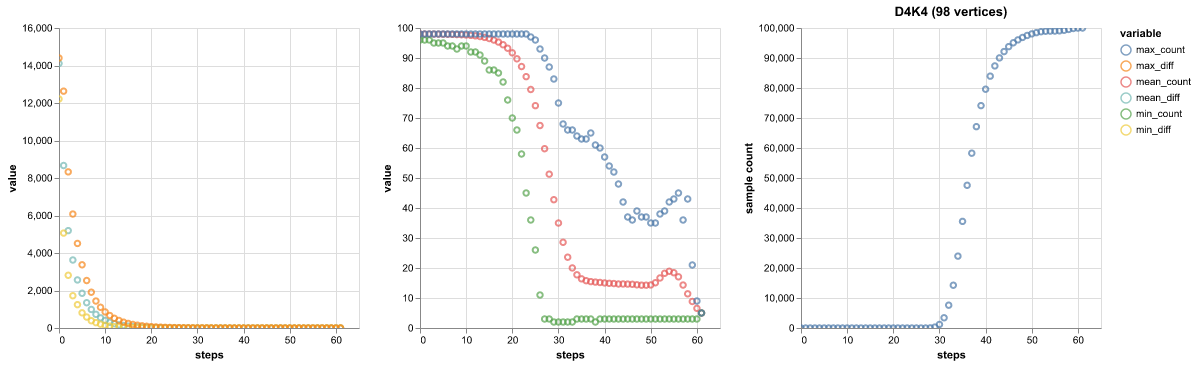

In [6]:
d4k4 = runGraph("d4k4", "D4K4 (98 vertices)")
plotGraph(d4k4)

### Twenty Chain Graph

Sample count: 100000, Max steps: 44


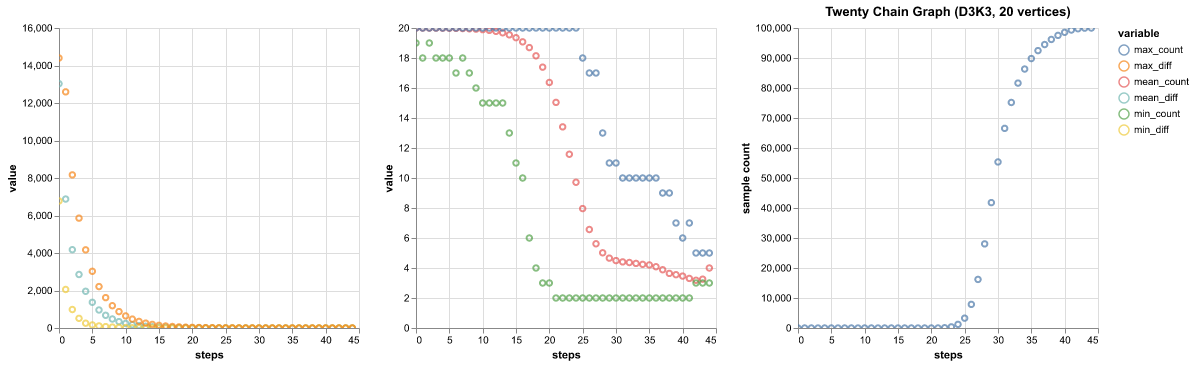

In [7]:
twenty = runGraph("twenty", "Twenty Chain Graph (D3K3, 20 vertices)")
plotGraph(twenty)

### D5K4

Sample count: 100000, Max steps: 49


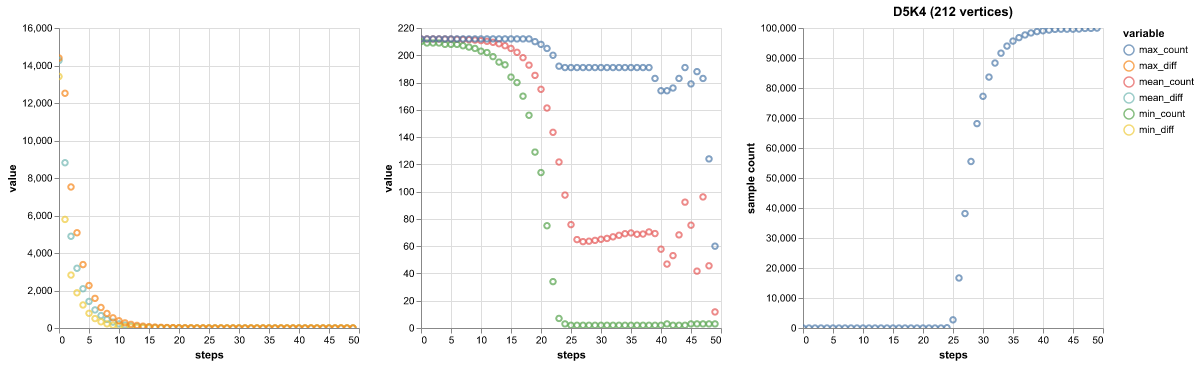

In [8]:
d5k4 =runGraph("d5k4", "D5K4 (212 vertices)")
plotGraph(d5k4)

### Hoffman Singleton

Sample count: 100000, Max steps: 14


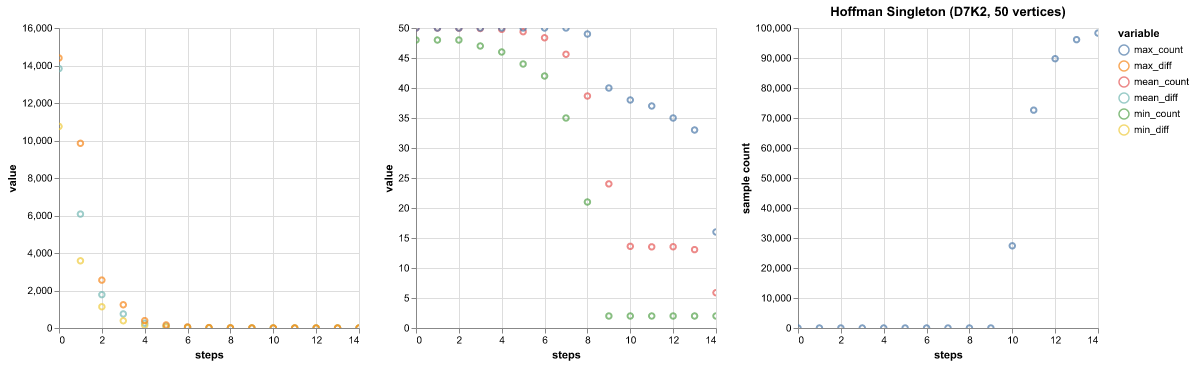

In [9]:
hoffman = runGraph("hoffman", "Hoffman Singleton (D7K2, 50 vertices)")
plotGraph(hoffman)

### Petersen

Sample count: 100000, Max steps: 20


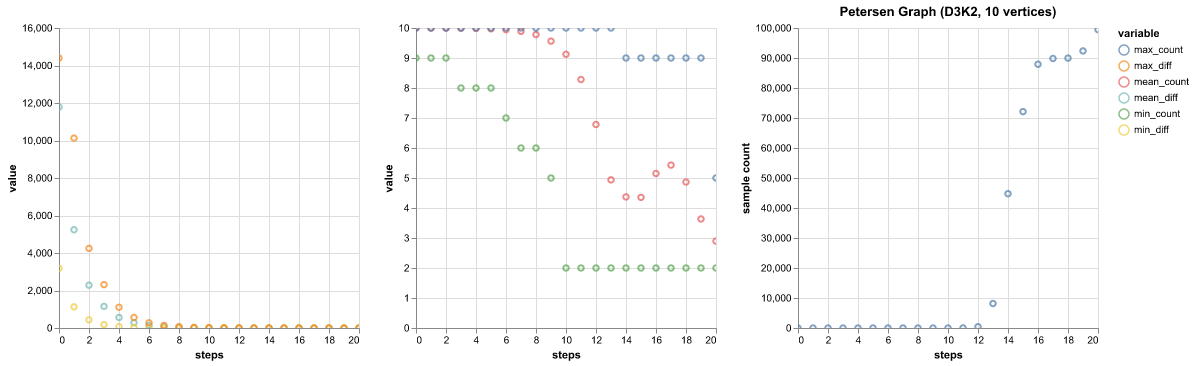

In [10]:
petersen = runGraph("petersen", "Petersen Graph (D3K2, 10 vertices)")
plotGraph(petersen)

### D3K4

Sample count: 100000, Max steps: 77


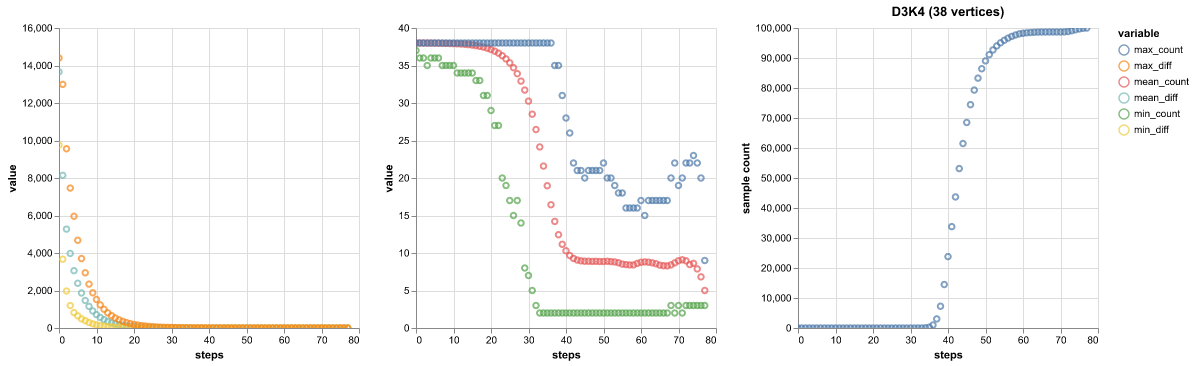

In [11]:
d3k4 = runGraph("d3k4", "D3K4 (38 vertices)")
plotGraph(d3k4)

### D4K3

Sample count: 100000, Max steps: 44


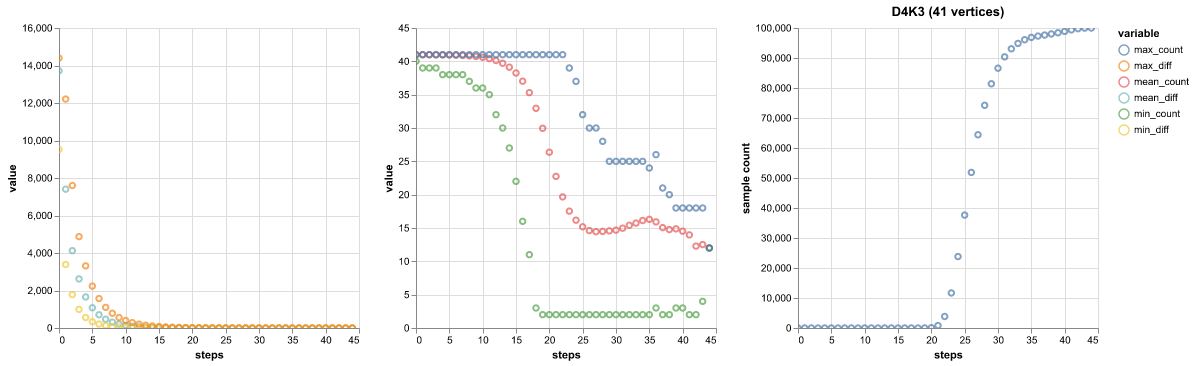

In [12]:
d4k3 = runGraph("d4k3", "D4K3 (41 vertices)")
plotGraph(d4k3)

### D5K3

Sample count: 100000, Max steps: 40


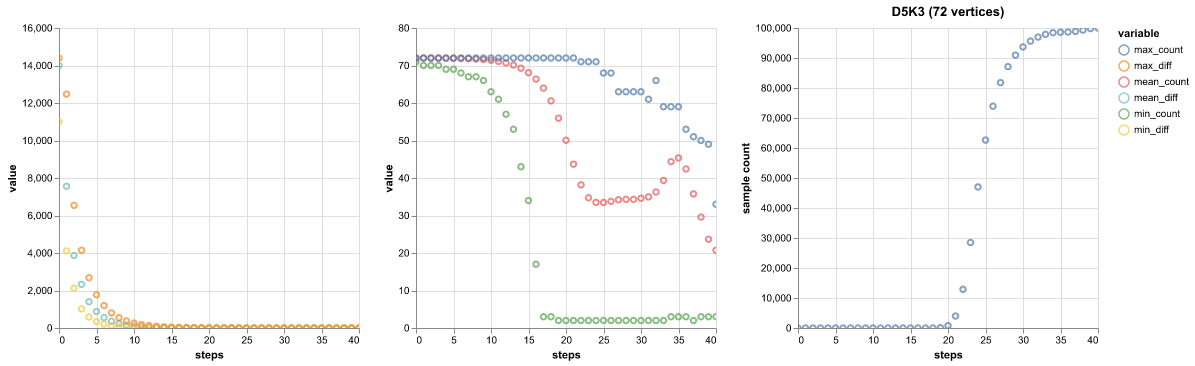

In [13]:
d5k3 = runGraph("d5k3", "D5K3 (72 vertices)")
plotGraph(d5k3)

# Convergence Plots

In [14]:
def show_all(plots):
    return alt.vconcat(
        *[alt.hconcat(*[r.convergence_plot for r in batch]) for batch in batched(plots, 3)
    ])

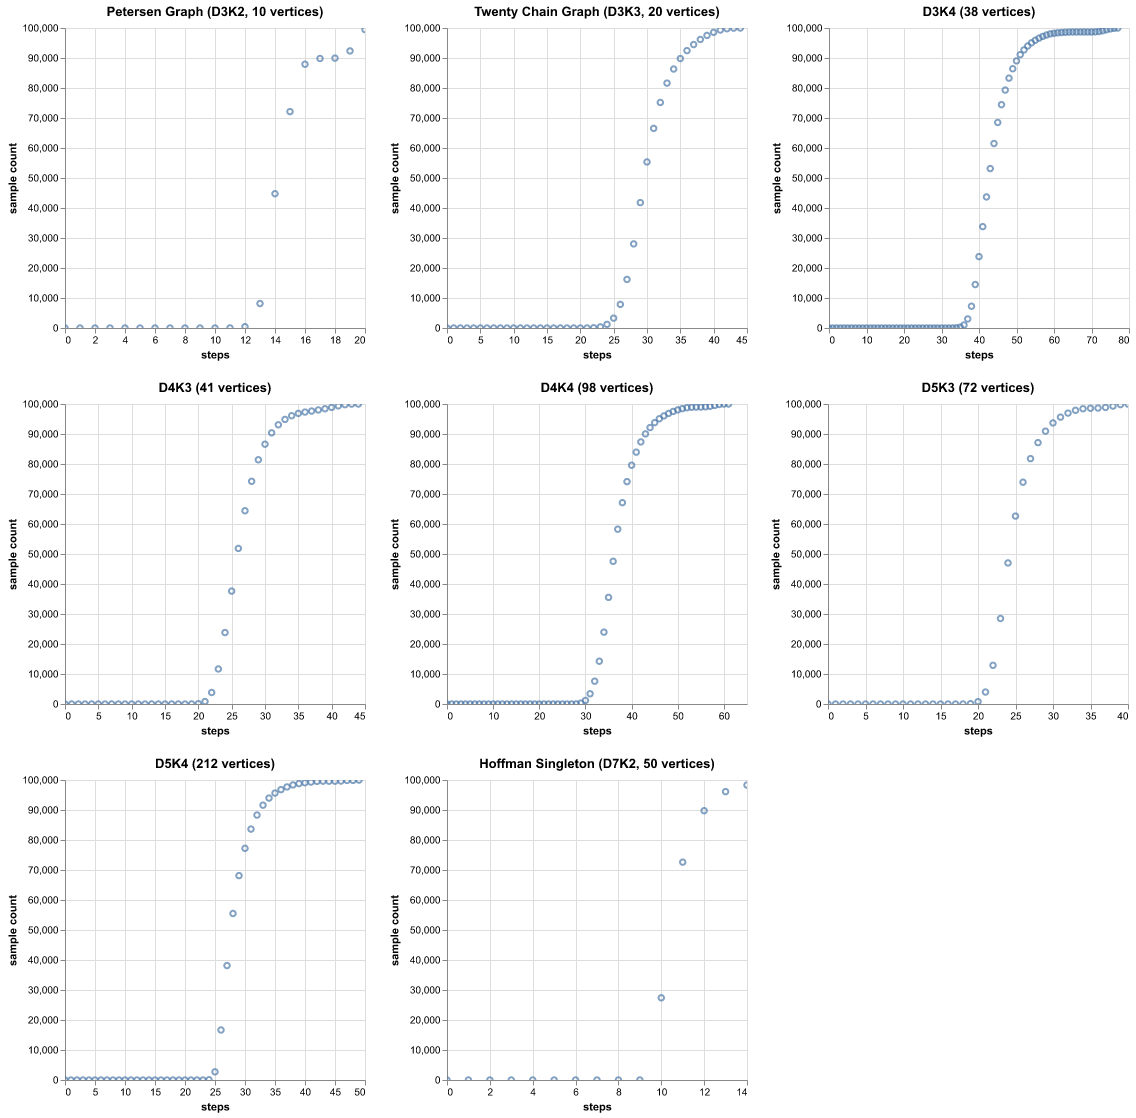

In [15]:
show_all([
    petersen,
    twenty,
    d3k4,
    d4k3,
    d4k4,
    d5k3,
    d5k4,
    hoffman,
])